In [1]:
# !pip install opencv-python
# !apt update && apt install -y libsm6 libxext6

# !apt-get install libxrender1
# #!sudo apt-get install libfontconfig1 libxrender1

In [2]:
import numpy as np
import time, math
import cv2
from tqdm import tqdm_notebook as tqdm

import tensorflow as tf
from tensorflow.keras.regularizers import l2
import tensorflow.contrib.eager as tfe

import matplotlib.pyplot as plt
% matplotlib inline

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [3]:
learning_rate = 0.4 
epochs = 25
batch_size = 512
end_percentage = 0.05
triangle_tilt = 0.7

In [4]:
# Loading the CIFAR10 60000 Training and 10000 Test data into respective numpy arrays
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()

n_train, n_test = X_train.shape[0], X_test.shape[0]
img_size = X_train.shape[1]
n_classes = y_train.max() + 1

In [5]:
X_train = X_train.astype('float32')/255
X_test = X_test.astype('float32')/255
Y_train = tf.keras.utils.to_categorical(y_train, n_classes)
Y_test = tf.keras.utils.to_categorical(y_test, n_classes)

In [6]:
X_train_mean = np.mean(X_train, axis=(0,1,2))
X_train_std = np.std(X_train, axis=(0,1,2))
print(X_train_mean, X_train_std)

[0.4914009  0.48215896 0.4465308 ] [0.24703279 0.24348423 0.26158753]


In [7]:
X_test_mean = np.mean(X_test, axis=(0,1,2))
X_test_std = np.std(X_test, axis=(0,1,2))
print(X_test_mean, X_test_std)

[0.49421427 0.4851322  0.45040992] [0.24665268 0.24289216 0.2615922 ]


In [8]:
X_train = (X_train - X_train_mean) / X_train_std
X_test = (X_test - X_test_mean) / X_test_std

#Random Cropping 

In [9]:
def random_crop(input_image,padding_pixels=4,random_crop_size=(32,32)):
          # Note: image_data_format is 'channel_last'
          assert input_image.shape[2] == 3
          
          #Pad by 4 pixels
          img = cv2.copyMakeBorder(input_image, padding_pixels, padding_pixels, padding_pixels, padding_pixels, cv2.BORDER_REPLICATE)
          
          height, width = img.shape[0], img.shape[1]
          dy, dx = random_crop_size
          x = np.random.randint(0, width - dx + 1)
          y = np.random.randint(0, height - dy + 1)
          return img[y:(y+dy), x:(x+dx), :]
        
tr_seq = list(range(len(X_train)))
train_func = lambda i:random_crop(X_train[i])
train_features = list(map(train_func,tr_seq))

train_features = np.asarray(train_features)
train_labels = Y_train 

In [10]:
def get_cutout_eraser_and_padcrop(p=0.5, s_l=0.3, s_h=0.3, r_1=0.3, r_2=1 / 0.3, max_erasures_per_image=1, pixel_level=True, random_crop_size=(32, 32), padding_pixels=4):
    """
    :param p:
    :param s_l: Minimum Area Proportion of Original that may be cut
    :param s_h: Maximum Area Proportion of Original that may be cut
    :param r_1: Min Aspect Ratio
    :param r_2: Max Aspect Ratio
    :param max_erasures_per_image:
    :param pixel_level:
    :return: Eraser to be used as Preprocessing Function
    """
    assert max_erasures_per_image >= 1

    def eraser(input_img):
        v_l = np.min(input_img)
        v_h = np.max(input_img)
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        mx = np.random.randint(1, max_erasures_per_image + 1)
        # print("Erasures = ",mx,end =", ")
        for i in range(mx):
            while True:
                s = np.random.uniform(s_l, s_h) * img_h * img_w
                r = np.random.uniform(r_1, r_2)
                w = int(np.sqrt(s / r))
                h = int(np.sqrt(s * r))
                left = np.random.randint(0, img_w)
                top = np.random.randint(0, img_h)

                if left + w <= img_w and top + h <= img_h:
                    break

            # print("W = ",w,"H = ",h,end =", ")

            if pixel_level:
                # print(np.max(img_c),np.min(img_c),v_l,v_h)
                c = np.random.uniform(v_l, v_h, (h, w, img_c))
                # print(c.shape,np.min(c),np.max(c),np.median(c))
            else:
                c = np.random.uniform(v_l, v_h)

            input_img[top:top + h, left:left + w, :] = c

        # print()
        return input_img
     
    
        
    def preproc_image(input_image):
      #return eraser
      return eraser(input_image)

    return preproc_image
      
        

In [11]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
   #featurewise_center=True,
   #featurewise_std_normalization=True,
   horizontal_flip=0.5,                 # randomly flip images                                     
   preprocessing_function=get_cutout_eraser_and_padcrop(p=0.8, s_l=0.25, s_h=0.25, r_1=0.2, r_2=1 / 0.3, max_erasures_per_image=1, pixel_level=False))

_ = datagen.fit(X_train)
train_iterator = datagen.flow(X_train, Y_train, batch_size=256, shuffle=False)

# X_e, Y_e = train_iterator.next()
# X_e = min_max_scale(X_e)
# show_examples(X_e[0:10], Y_e[0:10], classes = get_cifar10_labels())

In [12]:
datagen_validation = tf.keras.preprocessing.image.ImageDataGenerator()
datagen_validation.fit(X_test)
validation_iterator = datagen_validation.flow(X_test, Y_test, batch_size=batch_size, shuffle=False)

#Custom Image Data Generator for Augmentation 

Here storing all the augmented images and later will pick up half augmented from here and half from original images 

In [13]:
import h5py
f = h5py.File('aug_img.hdf5', 'w')
d = f.create_dataset('dataset', (600000,32,32,3),chunks=(256,32,32,3))
l = f.create_dataset('labels',(600000,10),chunks=(256,10))


batch_size=256
EPOCHS =12
aug_lbl=[]
tmp=0
for i in range(EPOCHS):
  print("tmp ", tmp)
  for j in range(len(train_iterator)):
    initial = j*batch_size+tmp
    train_gen = train_iterator.next()
    if(j == 195 ):
      final += 80
      d[initial:final]= train_gen[0]
      l[initial:final]= train_gen[1]
      continue 
      
    
    final = initial + 256
    d[initial:final]= train_gen[0]
    l[initial:final]= train_gen[1]
  
  tmp = final


tmp  0
tmp  50000
tmp  100000
tmp  150000
tmp  200000
tmp  250000
tmp  300000
tmp  350000
tmp  400000
tmp  450000
tmp  500000
tmp  550000


In [14]:
input_shape=(32, 32, 3)
num_outputs = 10

#David Net Architecture 

In [15]:
def block(input_layer,filters,stride=1):
  
  conv_1 = tf.keras.layers.Conv2D(filters, kernel_size=(3,3), padding='same', strides=stride, kernel_regularizer=l2(0.0001))(input_layer)
  
  bn_1 = tf.keras.layers.BatchNormalization(axis=3,momentum=0.9,epsilon=1e-5)(conv_1)
  
  activation_layer_b1 = tf.keras.layers.Activation('relu')(bn_1)
  
  return activation_layer_b1


input = tf.keras.layers.Input(shape=input_shape)
start = block(input,32)

layer_1 = block(start,64)
mp_1 = tf.keras.layers.AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding="same")(layer_1)

layer1_identity = tf.keras.layers.Conv2D(filters=32,kernel_size=(1, 1),strides=(1, 1),padding="same",kernel_regularizer=l2(0.0001))(mp_1)
layer1_res1 = block(layer1_identity,64)
layer1_res2 = block(layer1_res1,64)

concat1 = tf.keras.layers.concatenate([mp_1, layer1_res2])

layer_2 = block(concat1,128)
mp_2 = tf.keras.layers.AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding="same")(layer_2)

layer_3 = block(mp_2,256)
mp_3 = tf.keras.layers.AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding="same")(layer_3)

layer3_identity = tf.keras.layers.Conv2D(filters=128,kernel_size=(1, 1),strides=(1, 1),padding="same",kernel_regularizer=l2(0.0001))(mp_3)
layer3_res1 = block(layer3_identity,256)
layer3_res2 = block(layer3_res1,256)

concat2 = tf.keras.layers.concatenate([mp_3, layer3_res2])

gmp = tf.keras.layers.GlobalAveragePooling2D()(concat2)
dense = tf.keras.layers.Dense(units=num_outputs, activation="softmax")(gmp) #kernel_initializer="he_normal", 

model = tf.keras.models.Model(inputs=input, outputs=dense)


W0826 16:57:00.708470 140451500074816 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


#For slanted learning rate

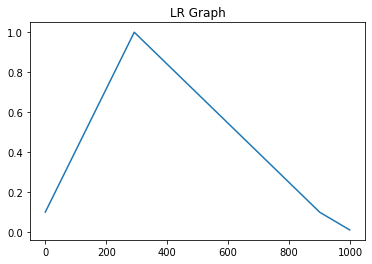

In [16]:
def min_max_scaler(iterations, num_iterations, end_percentage, min_val, max_val, invert = False, triangle_tilt = 0.65):
  non_slant_mid_cycle_id = int(num_iterations * ((1. - end_percentage)) / float(2))
  mid_cycle_id = int(triangle_tilt*int(num_iterations * ((1. - end_percentage)) / float(2)))
  value = 0
  if iterations > 2 * non_slant_mid_cycle_id:
    
    
      extra_iters = (iterations - 2 * non_slant_mid_cycle_id)
      current_percentage = 1 - (1 - 1/10)*extra_iters/(num_iterations - 2 * non_slant_mid_cycle_id)
            

  elif iterations >  mid_cycle_id:
      current_percentage = 1. - (iterations - mid_cycle_id) / (2*non_slant_mid_cycle_id - mid_cycle_id)
      
  else:
      current_percentage = iterations / mid_cycle_id
      
  if invert:
    if iterations > 2 * non_slant_mid_cycle_id:
      return max_val
    return max_val - current_percentage * (max_val - min_val)
  else:
    if iterations > 2 * non_slant_mid_cycle_id:
      return min_val * current_percentage
    return min_val + current_percentage * (max_val - min_val)
  
    

print("="*80)
scales = []
for i in range(1000):
  p = min_max_scaler(i,1000,0.1,min_val=0.1,max_val=1, invert=False)
  scales.append(p)
  
plt.plot(np.array(scales))
plt.title("LR Graph")
plt.show()

In [17]:
import os
import numpy as np
import warnings

from tensorflow.keras.callbacks import Callback
from tensorflow.keras import backend as K

from tensorflow.keras.layers import (
    Conv2D,
    MaxPooling2D,
    AveragePooling2D
)


# Code is ported from https://github.com/fastai/fastai
class OneCycleLR(Callback):
    def __init__(self,
                 epochs,
                 batch_size,
                 samples,
                 steps,
                 max_lr,
                 end_percentage=0.1,
                 scale=100,
                 maximum_momentum=0.95,
                 minimum_momentum=0.85,
                 triangle_tilt = 0.75,
                 verbose=True):
        """ This callback implements a cyclical learning rate policy (CLR).
        This is a special case of Cyclic Learning Rates, where we have only 1 cycle.
        After the completion of 1 cycle, the learning rate will decrease rapidly to
        100th its initial lowest value.
        # Arguments:
            max_lr: Float. Initial learning rate. This also sets the
                starting learning rate (which will be 10x smaller than
                this), and will increase to this value during the first cycle.
            end_percentage: Float. The percentage of all the epochs of training
                that will be dedicated to sharply decreasing the learning
                rate after the completion of 1 cycle. Must be between 0 and 1.
            scale_percentage: Float or None. If float, must be between 0 and 1.
                If None, it will compute the scale_percentage automatically
                based on the `end_percentage`.
            maximum_momentum: Optional. Sets the maximum momentum (initial)
                value, which gradually drops to its lowest value in half-cycle,
                then gradually increases again to stay constant at this max value.
                Can only be used with SGD Optimizer.
            minimum_momentum: Optional. Sets the minimum momentum at the end of
                the half-cycle. Can only be used with SGD Optimizer.
            verbose: Bool. Whether to print the current learning rate after every
                epoch.
        # Reference
            - [A disciplined approach to neural network hyper-parameters: Part 1 -- learning rate, batch size, weight_decay, and weight decay](https://arxiv.org/abs/1803.09820)
            - [Super-Convergence: Very Fast Training of Residual Networks Using Large Learning Rates](https://arxiv.org/abs/1708.07120)
        """
        super(OneCycleLR, self).__init__()

        if end_percentage < 0. or end_percentage > 1.:
            raise ValueError("`end_percentage` must be between 0 and 1")


        self.initial_lr = max_lr
        self.end_percentage = end_percentage
        self.scale = scale
        self.max_momentum = maximum_momentum
        self.min_momentum = minimum_momentum
        self.verbose = verbose

        if self.max_momentum is not None and self.min_momentum is not None:
            self._update_momentum = True
        else:
            self._update_momentum = False

        self.clr_iterations = 0.
        self.history = {}

        self.epochs = epochs
        self.batch_size = batch_size
        self.samples = samples
        self.steps = steps
        self.num_iterations = None
        self.mid_cycle_id = None

    def _reset(self):
        """
        Reset the callback.
        """
        self.clr_iterations = 0.
        self.history = {}

    def compute_lr(self):
        """
        Compute the learning rate based on which phase of the cycle it is in.
        - If in the first half of training, the learning rate gradually increases.
        - If in the second half of training, the learning rate gradually decreases.
        - If in the final `end_percentage` portion of training, the learning rate
            is quickly reduced to near 100th of the original min learning rate.
        # Returns:
            the new learning rate
        """
        new_lr = min_max_scaler(self.clr_iterations, self.num_iterations, self.end_percentage, self.initial_lr/self.scale, self.initial_lr, invert = False, triangle_tilt=triangle_tilt)
        return new_lr

    def compute_momentum(self):
        """
         Compute the momentum based on which phase of the cycle it is in.
        - If in the first half of training, the momentum gradually decreases.
        - If in the second half of training, the momentum gradually increases.
        - If in the final `end_percentage` portion of training, the momentum value
            is kept constant at the maximum initial value.
        # Returns:
            the new momentum value
        """    
        new_momentum = min_max_scaler(self.clr_iterations, self.num_iterations, self.end_percentage, self.min_momentum, self.max_momentum, invert = True, triangle_tilt=triangle_tilt)
        return new_momentum

    def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.steps is not None:
            self.num_iterations = self.epochs * self.steps
        else:
            if (self.samples % self.batch_size) == 0:
                remainder = 0
            else:
                remainder = 1
            self.num_iterations = (self.epochs + remainder) * self.samples // self.batch_size

        self.mid_cycle_id = int(self.num_iterations * ((1. - self.end_percentage)) / float(2))

        self._reset()
        K.set_value(self.model.optimizer.lr, self.compute_lr())

        if self._update_momentum:
            if not hasattr(self.model.optimizer, 'momentum'):
                raise ValueError("Momentum can be updated only on SGD optimizer !")

            new_momentum = self.compute_momentum()
            K.set_value(self.model.optimizer.momentum, new_momentum)

    def on_batch_end(self, epoch, logs=None):
        logs = logs or {}

        self.clr_iterations += 1
        new_lr = self.compute_lr()

        self.history.setdefault('lr', []).append(
            K.get_value(self.model.optimizer.lr))
        K.set_value(self.model.optimizer.lr, new_lr)

        if self._update_momentum:
            if not hasattr(self.model.optimizer, 'momentum'):
                raise ValueError("Momentum can be updated only on SGD optimizer !")

            new_momentum = self.compute_momentum()

            self.history.setdefault('momentum', []).append(
                K.get_value(self.model.optimizer.momentum))
            K.set_value(self.model.optimizer.momentum, new_momentum)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)

    def on_epoch_end(self, epoch, logs=None):
        if self.verbose:
            if self._update_momentum:
                print(" - lr: %0.5f - momentum: %0.2f " %
                      (self.history['lr'][-1], self.history['momentum'][-1]))

            else:
                print(" - lr: %0.5f " % (self.history['lr'][-1]))
                
    
    def plot(self):
        plt.title("LR-Plot")
        plt.plot(self.history['lr'])
        plt.xlabel("Epochs")
        plt.ylabel("LR")
        plt.show()
        
        plt.title("Momentum-Plot")
        plt.plot(self.history['momentum'])
        plt.xlabel("Epochs")
        plt.ylabel("Momentum")
        plt.show()

#One Cycle LR

In [18]:
olr = OneCycleLR(epochs=24, batch_size = batch_size,steps=98, 
                 samples=X_train.shape[0], max_lr=0.6, verbose = True, scale = 50, end_percentage=0.1,
                 maximum_momentum = 0.95, minimum_momentum=0.85, triangle_tilt=0.75)

In [19]:
sgd = tf.keras.optimizers.SGD(lr=0.08, decay=5e-4, momentum=0.9, nesterov=True)

# Compile the model
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

#Reading the HDF5 file of Augmented Images

In [20]:
data = tf.keras.utils.HDF5Matrix('./aug_img.hdf5','dataset')
label = tf.keras.utils.HDF5Matrix('./aug_img.hdf5','labels')

# f = h5py.File('aug_img.hdf5', 'r')
# data = f['dataset'][:]
# label = f['labels'][:]
# f.close()

#Custom Data Generator 

It picks Half of batch from Augmented images and other half from 

Original Images.

In [21]:
import numpy as np
#import keras
import random
class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, data, label, train_features,train_labels, batch_size=512, dim=(32,32), n_channels=3,
                 n_classes=10, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.label = label
        self.data = data
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.train_features = train_features
        self.train_labels = train_labels
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.data) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        
        # Generate indexes of the batch
        #indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        aug_ran = random.randrange(0,len(self.data)-256)
        wo_aug = random.randrange(0,len(self.train_features)-256)
        #print(aug_ran)
        train_data_aug = lambda i: (np.array(self.data[i:i+256]),np.array(self.label[i:i+256]))
        train_data_wo = lambda i: (np.array(self.train_features[i:i+256]),np.array(self.train_labels[i:i+256]))
        
        
        X = np.concatenate((train_data_aug(aug_ran)[0],train_data_wo(wo_aug)[0]),axis=0)
        y = np.concatenate((train_data_aug(aug_ran)[1],train_data_wo(wo_aug)[1]),axis=0)
        #print("label",y.shape, " " ,X.shape)
        #plt.imshow(X[0])
        # Generate data
        #X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.data))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
            
gen = DataGenerator(data,label,train_features,train_labels,512)

In [22]:
# train the model
start = time.time()
# Train the model

model_info = model.fit_generator(gen,
                                 steps_per_epoch = 98, epochs = 24, 
                                 validation_data = validation_iterator, 
                                 validation_steps = len(validation_iterator),
                                 verbose=1, callbacks=[olr])
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
# plot_model_history(model_info)

Epoch 1/24
98/98 [==============================] - 10s 106ms/step - loss: 1.6151 - acc: 0.4562 - val_loss: 1.3745 - val_acc: 0.5565
Epoch 2/24
98/98 [==============================] - 5s 50ms/step - loss: 1.1218 - acc: 0.6401 - val_loss: 1.3654 - val_acc: 0.6007
Epoch 3/24
98/98 [==============================] - 5s 50ms/step - loss: 0.9214 - acc: 0.7185 - val_loss: 0.9263 - val_acc: 0.7388
Epoch 4/24
98/98 [==============================] - 5s 50ms/step - loss: 0.8299 - acc: 0.7568 - val_loss: 0.9556 - val_acc: 0.7251
Epoch 5/24
98/98 [==============================] - 5s 49ms/step - loss: 0.7767 - acc: 0.7789 - val_loss: 0.8052 - val_acc: 0.7885
Epoch 6/24
98/98 [==============================] - 5s 50ms/step - loss: 0.7240 - acc: 0.8030 - val_loss: 0.9380 - val_acc: 0.7564
Epoch 7/24
98/98 [==============================] - 5s 49ms/step - loss: 0.6767 - acc: 0.8217 - val_loss: 0.8936 - val_acc: 0.7710
Epoch 8/24
98/98 [==============================] - 5s 50ms/step - loss: 0.6499 -

In [23]:
# compute test accuracy
result = model.evaluate_generator(validation_iterator, steps = len(validation_iterator))
print(result)

[0.4648878753185272, 0.9088]
